In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, set_seed

from datasets import load_dataset

# from torchao.dtypes.floatx import to_scaled_tc_floatx
# from torchao.ops import quant_llm_linear


def time_pytorch_function(func, input):
    # Функция для имерения скорости расчета `func` для входа `input`

    # CUDA IS ASYNC so can't use python time module
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        func(*input)

    start.record()
    func(*input)
    end.record()
    torch.cuda.synchronize()
    
    return start.elapsed_time(end)

def print_memory():
    # Функция измерения затраченной GPU памяти
    device='cuda'
    mem_allocated = torch.cuda.memory_allocated(device=device) / 1024**3
    mem_reserved = torch.cuda.memory_allocated(device=device) / 1024**3
    print(f"allocated: {mem_allocated:,.2f} gb")
    print(f" reserved: {mem_reserved:,.2f} gb")


import random

# Load and process wikitext2 dataset
def get_wikitext2(nsamples=128, seed=0, seqlen=2048, tokenizer=None):
    # Load test datasets
    testdata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testdata['text']), return_tensors='pt')
    trainloader = None
    return trainloader, testenc


# Function to evaluate perplexity (ppl) specifically on the wikitext dataset
def eval_ppl_wikitext(model, testenc, bs=1, device=None):
    # Get input IDs
    testenc = testenc.input_ids

    # Calculate number of samples
    nsamples = testenc.numel() // model.seqlen

    # List to store negative log likelihoods
    nlls = []
    print(f"nsamples {nsamples}")

    # Loop through each batch
    for i in range(0,nsamples,bs):
        if i % 50 == 0:
            print(f"sample {i}")

        # Calculate end index
        j = min(i+bs, nsamples)

        # Prepare inputs and move to device
        inputs = testenc[:,(i * model.seqlen):(j * model.seqlen)].to(device)
        inputs = inputs.reshape(j-i, model.seqlen)

        # Forward pass through the model
        lm_logits = model(inputs).logits

        # Shift logits and labels for next token prediction
        shift_logits = lm_logits[:, :-1, :].contiguous()
        shift_labels = inputs[:, 1:]

        # Compute loss
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))

        # Calculate negative log likelihood
        neg_log_likelihood = loss.float() * model.seqlen * (j-i)

        # Append to list of negative log likelihoods
        nlls.append(neg_log_likelihood)

    # Compute perplexity
    ppl = torch.exp(torch.stack(nlls).sum() / (nsamples * model.seqlen))

    # Empty CUDA cache to save memory
    torch.cuda.empty_cache()

    return ppl.item()


# Function to evaluate perplexity (ppl) on a specified model and tokenizer
def eval_ppl(model, tokenizer, device=torch.device("cuda:0")):
    # Set dataset
    dataset = "wikitext2"
    model.seqlen = 2048

    # Print status
    print(f"evaluating on {dataset}")

    # Get the test loader
    _, testloader = get_wikitext2(seqlen=model.seqlen, tokenizer=tokenizer)

    # Evaluate ppl in no grad context to avoid updating the model
    with torch.no_grad():
        ppl_test = eval_ppl_wikitext(model, testloader, 1, device)
    return ppl_test

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch import nn
from transformers.models.qwen3.modeling_qwen3 import Qwen3MLP
from transformers.models.llama.modeling_llama import LlamaMLP
from transformers.activations import ACT2FN
from torch.sparse import to_sparse_semi_structured, SparseSemiStructuredTensorCUTLASS, SparseSemiStructuredTensorCUSPARSELT

class MLP_act_sp(nn.Module):
    def __init__(self, config, backend=None):
        super().__init__()
        if hasattr(config, "mlp_bias"):
            bias = config.mlp_bias
        else:
            bias = False
        self.backend = backend

        self.config = config
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size        
        self.gate_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=bias)
        self.up_proj = nn.Linear(self.hidden_size, self.intermediate_size, bias=bias)
        self.down_proj = nn.Linear(self.intermediate_size, self.hidden_size, bias=bias)
        self.act_fn = ACT2FN[config.hidden_act]

    def forward(self, x):
        if self.backend is None:
            down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
        elif self.backend == "cusparselt":
            bs, seq_len, _ = x.shape
            x_flat = x.view(-1, self.hidden_size)
            pruned_x = SparseSemiStructuredTensorCUSPARSELT.prune_dense_static_sort(x_flat)
            down_proj = self.down_proj(self.act_fn(self.gate_proj(pruned_x)) * self.up_proj(pruned_x))
        elif self.backend == "cutlass":
            bs, seq_len, _ = x.shape
            x_flat = x.view(-1, self.hidden_size)
            pruned_x = SparseSemiStructuredTensorCUTLASS.prune_dense_static_sort(x_flat)
            
            # down_proj = self.down_proj(self.act_fn(self.gate_proj(pruned_x)) * self.up_proj(pruned_x))
            out_gate_proj = self.gate_proj(x_flat).view(bs, seq_len, -1)
            out_up_proj = self.up_proj(x_flat).view(bs, seq_len, -1)
            # down_proj = self.down_proj(self.act_fn(out_gate_proj) * out_up_proj)  

            in_down_proj = self.act_fn(out_gate_proj) * out_up_proj
            in_down_proj = in_down_proj.view(-1, self.intermediate_size)
            pruned_x = SparseSemiStructuredTensorCUTLASS.prune_dense_static_sort(in_down_proj)
            down_proj = self.down_proj(pruned_x)             
            down_proj = down_proj.view(bs, seq_len, self.hidden_size)

        return down_proj
    
    @classmethod
    def from_original(cls, orig_MLP, backend=None):
        mlp_sp = cls(orig_MLP.config, backend)
        mlp_sp.gate_proj = orig_MLP.gate_proj
        mlp_sp.up_proj = orig_MLP.up_proj
        mlp_sp.down_proj = orig_MLP.down_proj

        return mlp_sp

In [3]:
# model_path = "/home/LLaMA/huggingface/Qwen3-14B"
model_path = "/home/LLaMA/huggingface/meta-llama-3.1-8b"

# model_path = "/home/LLaMA/huggingface/Qwen3-14B"
# config = AutoConfig.from_pretrained(model_path)

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    # torch_dtype=torch.bfloat16,
    trust_remote_code = True,
    device_map = 'cuda:0'
)

Loading checkpoint shards:  25%|██▌       | 1/4 [08:17<24:51, 497.05s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 44.38 GiB of which 117.56 MiB is free. Process 3790346 has 174.00 MiB memory in use. Process 2714302 has 32.82 GiB memory in use. Process 3582483 has 11.26 GiB memory in use. Of the allocated memory 10.63 GiB is allocated by PyTorch, and 339.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [6]:
root_module = model 
module_name_dict = {name: module for name, module in root_module.named_modules()}
for name, module in module_name_dict.items():
    # if isinstance(module, Qwen3MLP):
    if isinstance(module, LlamaMLP):
    # if isinstance(module, MLP_act_sp):
    # if isinstance(module, torch.nn.Linear) and (name.find("down_proj") != -1):
        ind = name.rfind(".")
        if ind == -1:
            father = module_name_dict[""]
        else:
            father = module_name_dict[name[:ind]]
        
        sparse_mlp = MLP_act_sp.from_original(module, backend="cutlass")
        setattr(father, name[ind + 1 :], sparse_mlp)
        # print(f"replace layer {name} with {q_linear}")
        # del module

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [8]:
ppl = eval_ppl(model, tokenizer)

evaluating on wikitext2


Token indices sequence length is longer than the specified maximum sequence length for this model (289076 > 131072). Running this sequence through the model will result in indexing errors


nsamples 141
sample 0


/opt/conda/lib/python3.11/site-packages/torch/sparse/semi_structured.py:115: UserWarning: The PyTorch API of SparseSemiStructuredTensor is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.sparse module for further information about the project.
  warnings.warn(


sample 50
sample 100


In [9]:
ppl #up_proj

110.43801879882812

In [ ]:
ppl #gate_proj

99.568115234375

In [9]:
ppl #down_proj

4142.78076171875

In [ ]:
ppl #down_proj + up_proj

136190.21875

In [ ]:
ppl #orig 1m 44s

8.645155906677246

In [8]:
ppl = eval_ppl(model, tokenizer)

evaluating on wikitext2


Token indices sequence length is longer than the specified maximum sequence length for this model (289076 > 131072). Running this sequence through the model will result in indexing errors


nsamples 141
sample 0


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 44.38 GiB of which 32.62 MiB is free. Process 3893576 has 15.30 GiB memory in use. Process 4170050 has 29.01 GiB memory in use. Of the allocated memory 14.98 GiB is allocated by PyTorch, and 16.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
ppl # 1m 40s up_proj

32.3795051574707

In [ ]:
ppl # 1m 44s gate_proj

7053.65673828125

In [8]:
ppl # 1m 44s down_proj

31.703990936279297

In [8]:
ppl = eval_ppl(model, tokenizer)
ppl

evaluating on wikitext2


nsamples 146
sample 0


TypeError: Linear.forward() takes 2 positional arguments but 3 were given

31.703990936279297

In [6]:
quantize_(model, int4_weight_only(layout=MarlinSparseLayout()))

In [6]:
ppl = eval_ppl(model, tokenizer)

evaluating on wikitext2


Token indices sequence length is longer than the specified maximum sequence length for this model (299078 > 131072). Running this sequence through the model will result in indexing errors


nsamples 146
sample 0
sample 50
sample 100


In [7]:
ppl

8.645155906677246

In [16]:
ppl

63.01717758178711

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
torch.cuda.synchronize()
end.record()


Running benchmark with BT=1024, INPUT_SIZE=14336, OUTPUT_SIZE=4096, dtype=torch.float16 provider=dense
Running benchmark with BT=1024, INPUT_SIZE=14336, OUTPUT_SIZE=4096, dtype=torch.float16 provider=cutlass
Running benchmark with BT=1024, INPUT_SIZE=14336, OUTPUT_SIZE=4096, dtype=torch.float16 provider=cusparselt
Running benchmark with BT=2048, INPUT_SIZE=14336, OUTPUT_SIZE=4096, dtype=torch.float16 provider=dense
Running benchmark with BT=2048, INPUT_SIZE=14336, OUTPUT_SIZE=4096, dtype=torch.float16 provider=cutlass
Running benchmark with BT=2048, INPUT_SIZE=14336, OUTPUT_SIZE=4096, dtype=torch.float16 provider=cusparselt
Running benchmark with BT=4096, INPUT_SIZE=14336, OUTPUT_SIZE=4096, dtype=torch.float16 provider=dense
Running benchmark with BT=4096, INPUT_SIZE=14336, OUTPUT_SIZE=4096, dtype=torch.float16 provider=cutlass
Running benchmark with BT=4096, INPUT_SIZE=14336, OUTPUT_SIZE=4096, dtype=torch.float16 provider=cusparselt
Running benchmark with BT=8192, INPUT_SIZE=14336, OU

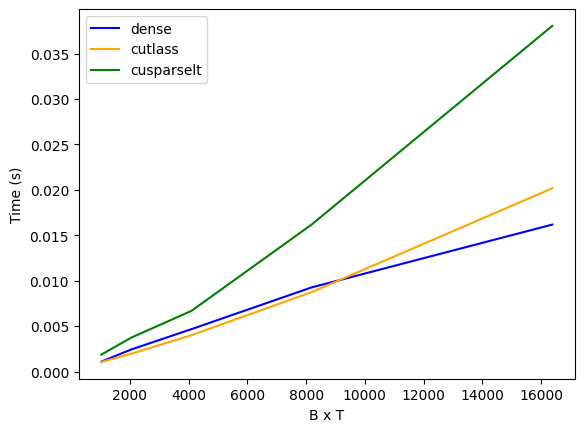

Semi-Structural:
        BT     dense   cutlass  cusparselt
0   1024.0  0.001089  0.001058    0.001860
1   2048.0  0.002433  0.001961    0.003739
2   4096.0  0.004668  0.004002    0.006679
3   8192.0  0.009262  0.008747    0.016191
4  16384.0  0.016173  0.020165    0.038043


In [19]:
import torch
import triton
from torch.sparse import to_sparse_semi_structured, SparseSemiStructuredTensorCUTLASS, SparseSemiStructuredTensorCUSPARSELT
from pathlib import Path

def test_speed(func, _iter):

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    times = []
    
    for _ in range(_iter):
        start.record()
        func()
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end) / 1000)        

    total_time = sum(times) / _iter

    return total_time

@triton.testing.perf_report(
    [
        triton.testing.Benchmark(
            x_names=["BT"],
            x_vals=[2**i for i in range(10, 15)], # 1024, 2048, 4096
            xlabel="B x T",
            line_arg="provider",
            line_vals=["dense", "cutlass", "cusparselt"],
            line_names=["dense", "cutlass", "cusparselt"],
            styles=[
                ("blue", "solid"),
                ("orange", "solid"),
                ("green", "solid"),
            ],
            ylabel="Time (s)",
            plot_name="Semi-Structural",
            args={"INPUT_SIZE": 14336, "OUTPUT_SIZE": 4096, "dtype": torch.float16},
        )
    ]
)
def bench_speed_semi_structural(BT, INPUT_SIZE, OUTPUT_SIZE, provider, dtype, device="cuda"):
    print(
        f"Running benchmark with BT={BT}, INPUT_SIZE={INPUT_SIZE}, OUTPUT_SIZE={OUTPUT_SIZE}, dtype={dtype} provider={provider}"
    )

    _input = torch.randn(BT, INPUT_SIZE, requires_grad=False, dtype=dtype, device=device)
    weight = torch.randn(INPUT_SIZE, OUTPUT_SIZE, requires_grad=False, dtype=dtype, device=device)

    def fwd():
        if provider == "dense":
            return _input @ weight
        elif provider == "cutlass":
            pruned_input = SparseSemiStructuredTensorCUTLASS.prune_dense_static_sort(_input)
            return pruned_input._mm(weight)
        elif provider == "cusparselt":
            pruned_input = SparseSemiStructuredTensorCUSPARSELT.prune_dense_static_sort(_input)
            return pruned_input._mm(weight)
        
    time = test_speed(fwd, _iter=100)
    return time

df = bench_speed_semi_structural.run(show_plots=True, print_data=True, return_df=True)

In [17]:
path_to_folder = Path("/home/Quantization/yandex_seminar/speculative_decoding/data/")
file_name = 'A40_llama_4096x14336' + '.txt'
path_to_file = path_to_folder / file_name 
df[0].to_csv(path_to_file, index=False)
df[0]

,BT,dense,cutlass,cusparselt
0,1024.0,0.001104,0.000885,0.001739
1,2048.0,0.002059,0.001751,0.002683
2,4096.0,0.004168,0.003772,0.005187
3,8192.0,0.008211,0.008859,0.011041
4,16384.0,0.016410,0.017807,0.030562


In [ ]:
def test_memory(func, _iter):
    total_mem = []

    for _ in range(_iter):
        torch.cuda.memory.reset_peak_memory_stats()
        func()
        mem = torch.cuda.max_memory_allocated() / (2**20)
        total_mem.append(mem)

    return sum(total_mem) / len(total_mem)

@triton.testing.perf_report(
    [
        triton.testing.Benchmark(
            x_names=["BT"],
            x_vals=[2**i for i in range(10, 13)], # 1024, 2048, 4096
            xlabel="B x T",
            line_arg="provider",
            line_vals=["liger", "huggingface"],
            line_names=["Liger", "Hugging Face"],
            styles=[
                ("blue", "solid"),
                ("orange", "solid"),
            ],
            ylabel="GPU memory usage (MB)",
            plot_name="fused-linear-cross-entropy-memory-benchmark",
            args={"H": 4096, "V": 128256, "dtype": torch.float32},
        )
    ]
)
def bench_memory_cross_entropy(BT, H, V, provider, dtype, device="cuda"):
    print(
        f"Running benchmark with BT={BT}, H={H}, V={V}, dtype={dtype} provider={provider}"
    )
    torch_lm_head_ce = TorchLMHeadCE(H=H, V=V, dtype=dtype).to(device)
    liger_lm_head_ce = LigerLMHeadCE(H=H, V=V, dtype=dtype).to(device)

    _input = torch.randn(BT, H, requires_grad=True, dtype=dtype, device=device)
    target = torch.randint(V, (BT, 1), dtype=torch.long, device=device).squeeze(1)

    def fwd():
        if provider == "liger":
            return liger_lm_head_ce(_input, target)
        elif provider == "huggingface":
            return torch_lm_head_ce(_input, target)

    def full():
        y = fwd()
        y.backward()

    mem = test_memory(full, _iter=10)
    return mem


bench_memory_cross_entropy.run(show_plots=True, print_data=True)

In [10]:
import torch 

from torch.sparse import to_sparse_semi_structured, SparseSemiStructuredTensorCUTLASS

def time_pytorch_function(func, input):
    # Функция для имерения скорости расчета `func` для входа `input`

    # CUDA IS ASYNC so can't use python time module
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        func(*input)

    start.record()
    func(*input)
    end.record()
    torch.cuda.synchronize()
    
    return start.elapsed_time(end)

input = torch.zeros((5120, 5120)).half().cuda()
input = torch.zeros((17408)).half().cuda()
# input = None



In [11]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

# mat1 = torch.randn(5120, 5120).half().cuda()
# mat2 = torch.randn(5120, 5120).half().cuda()

mat1 = torch.randn(128, 5120).half().cuda()
mat2 = torch.randn(5120, 5120).half().cuda()

for _ in range(5):
    mat1 @ mat2

start.record()
mat1 @ mat2
end.record()
torch.cuda.synchronize()

start.elapsed_time(end)

0.0992640033364296

/opt/conda/lib/python3.11/site-packages/torch/sparse/semi_structured.py:115: UserWarning: The PyTorch API of SparseSemiStructuredTensor is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.sparse module for further information about the project.
  warnings.warn(


In [13]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

for _ in range(5):
    mat1._mm(mat2)

start.record()
mat1._mm(mat2)
end.record()
torch.cuda.synchronize()

start.elapsed_time(end)

0.09523200243711472

In [ ]:
torch.sparse.admm()

In [10]:
max_new_tokens = 50
use_cache =True
prompt = "Что такое компьютер?"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(torch.device("cuda:0"))
output = model.generate(input_ids, max_new_tokens=max_new_tokens, use_cache=use_cache)
tokenizer.batch_decode(output)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [8]:
def create_prompt(text: str, tokenizer) -> str:
    messages = [
        {
            "role": "system",
            "content": "You are a friendly chatbot who always responds as superhuman intelligence AI",
        },
        {"role": "user", "content": text},
    ]
    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )


# Some queries for LLMs
texts = [
    "What are the pros/cons of ChatGPT vs Open Source LLMs?",
    "Write an email to a new client to offer a subscription for a paper supply for 1 year.",
    "I have $10,000 USD for investment. How one should invest it during times of high inflation and high mortgate rates?",
    "Write a function in python that calculates the square of a sum of two numbers.",
]

In [1]:
import torch
from torchao.dtypes.floatx import to_scaled_tc_floatx
from torchao.ops import quant_llm_linear

In [15]:
fp32_weight = torch.randn(1024, 512).cuda().half()
# ebits, mbits = 3, 2
ebits, mbits = 3, 0

In [16]:
# pre-process the weight. this will quantize the weight to FP6 and pack it in a special
# layout for tensor cores. refer to paper for more details.
fp6_weight, scales = to_scaled_tc_floatx(fp32_weight, ebits, mbits)

In [17]:
fp16_act = torch.randn(1, 512).cuda().half()
outputs = quant_llm_linear(ebits, mbits, fp16_act, fp6_weight, scales)  # shape (1, 1024)

RuntimeError: FP4 E3M0 is not supported.

In [8]:
outputs

tensor([[ 21.8281,  33.8125, -27.0938,  ...,  29.4688,  19.3750,  -8.3984]],
       device='cuda:0', dtype=torch.float16)